# **Data preparation**

The first step of this process is to obtain the conversation on TXT format. The easiest way to export an entire chat history, not including video or photos from your cell phone, is to use the built-in “Export Chat” feature, following these steps.
1. Open an individual or a group chat.
2. Tap the Menu button shown in the image below.
3. Tap the More button.
4. Select Export Chat.
5. Tap Without Media from the options that are given.
6. Select an option to share TXT file.

# **Importing Libraries**
The following analysis uses a series of tools to develop and easy mechanism to generate charts and graphics. 

The imported libraries where:

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


# Load DataFrame from txt file
Parse and read the chat messages into 3 columns (date, person, message).

In [2]:
# Read txt data file

data = pd.read_table('../input/whatsapp-chat-momtxt/whatsapp_chat_mom.txt', names=['text'], header=None)

#get rid of top 2 rows (e.g. "this chat is encrypted" etc.)
data = data.iloc[3:]

# parse the data into the columns 'date', 'person', and 'message'
data[['DateTime','rest']] = data['text'].str.split(']', expand=True, n=1)
data[['person','message']] = data['rest'].str.split(':',expand=True, n=1)

data.drop(['text','rest'], axis=1, inplace=True)

Let's take a look at our dataset!

In [3]:
data.head()

,DateTime,person,message
3,"‎[7/12/2018, 6:37:37 PM",Mom,‎audio omitted
4,"[7/12/2018, 6:41:04 PM",Mom,Adrian has a question: Can you just take Math...
5,"[7/12/2018, 6:41:56 PM",Sara,Yea
6,"[7/12/2018, 6:41:59 PM",Sara,What’s SL
7,"[7/12/2018, 6:42:17 PM",Sara,HL is higher level or sth right?


Using another pandas method called info(), we can have a lot of information about columns of DataFrames, such as format, number of nan and the count of records per column, in this way we found that format of DateTime column is string, we will transform this column to a suitable date and time format to be able to analyze these aspects.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5545 entries, 3 to 5547
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  5545 non-null   object
 1   person    5365 non-null   object
 2   message   5364 non-null   object
dtypes: object(3)
memory usage: 130.1+ KB


# **Data Cleaning**
1. Remove all the "image omitted"
2. Remove all rows with null values
3. Convert column DateTime into datatime object
4. With DateTime column, add 4 new columns (weekday, month_sent, date, hour)
5. With Messages column, add 4 new columns (emojis, urlcount, Letter_Count & Word_Count)

In [5]:
# get rid of all the "image omitted"
data = data[~data["message"].str.contains("omitted", na=False)]

# sort of the date into a proper date column
data['DateTime'] = data['DateTime'].map(lambda x: x.replace(',',''))
data['DateTime'] = data['DateTime'].map(lambda x: x.strip('['))
data['DateTime'] = pd.to_datetime(data['DateTime'], format="%d/%m/%Y %I:%M:%S %p", errors='coerce')

# remove null rows 
print('Number of rows before dropping null: {}'.format(data.shape[0]))
data = data[data['DateTime'].notnull()]
print('Number of rows after dropping null: {}'.format(data.shape[0]))

Number of rows before dropping null: 5016
Number of rows after dropping null: 4835


In [6]:
#Create 4 new columns to sort datetime
#weekday
data['weekday'] = data['DateTime'].apply(lambda x: x.day_name())

#month sent
data['month_sent'] = data['DateTime'].apply(lambda x: x.month_name())

#date
data['date'] = [d.date() for d in data['DateTime']]

#hour
data['hour'] = [d.time().hour for d in data['DateTime']]

In [7]:
#column urlcount
URLPATTERN = r'(https?://\S+)'
data['urlcount'] = data.message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

#column Letter_Count
data['Letter_Count'] = data['message'].apply(lambda s : len(s))

#column Word_Count
data['Word_Count'] = data['message'].apply(lambda s : len(s.split(' ')))

#create emoji column
def split_count(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)  
    return emoji_list

data["emoji"] = data["message"].apply(lambda x: split_count(x))

Let's see what the cleaned dataframe looks like now

In [8]:
data.head()

,DateTime,person,message,weekday,month_sent,date,hour,urlcount,Letter_Count,Word_Count,emoji
4,2018-12-07 18:41:04,Mom,Adrian has a question: Can you just take Math...,Friday,December,2018-12-07,18,0,62,15,[]
5,2018-12-07 18:41:56,Sara,Yea,Friday,December,2018-12-07,18,0,4,2,[]
6,2018-12-07 18:41:59,Sara,What’s SL,Friday,December,2018-12-07,18,0,10,3,[]
7,2018-12-07 18:42:17,Sara,HL is higher level or sth right?,Friday,December,2018-12-07,18,0,33,8,[]
8,2018-12-07 18:42:26,Mom,Right,Friday,December,2018-12-07,18,0,6,2,[]


# Data Analysis
We would like to create a series of data visualisation to understand the data better.

This chart shows the number of messages per day:

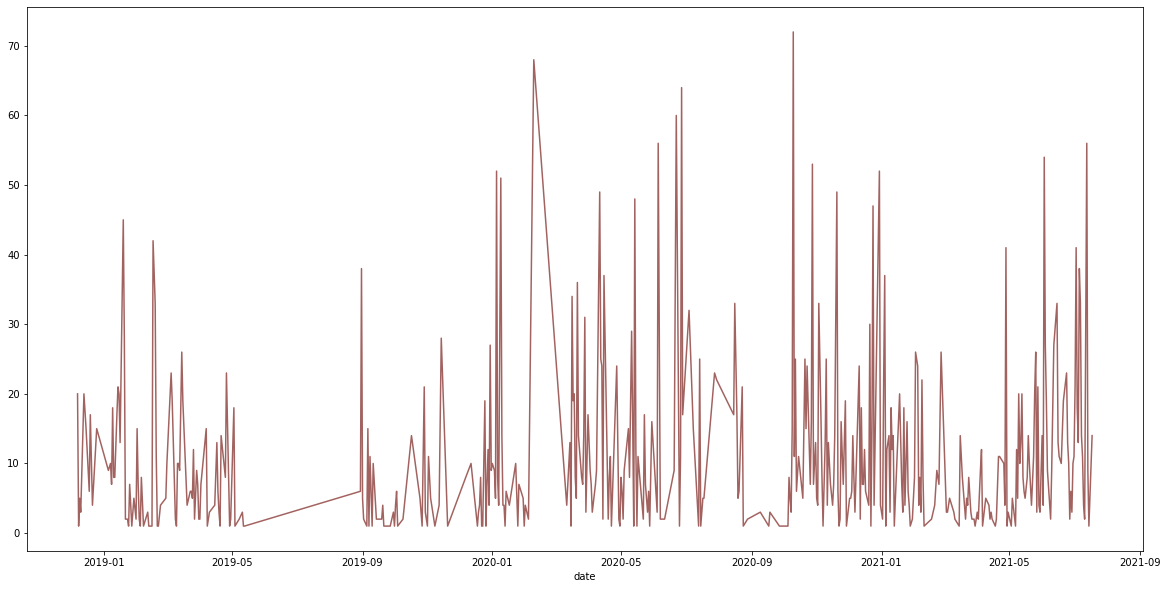

In [9]:
date_grouped = data.groupby('date')['message'].count().plot(kind='line', figsize=(20,10), color='#A26360')

Let's find out which weekday has the highest message frequency!

In [10]:
weekday_grouped_msg =  (data.set_index('weekday')['message']
                          .groupby(level=0)
                          .value_counts()
                          .groupby(level=0)
                          .sum()
                          .reset_index(name='count'))
weekday_grouped_msg

fig = px.line_polar(weekday_grouped_msg, r='count', theta='weekday', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=False
)
fig.show()

What time of day is it most common to send messages in this chat?

In [11]:
hour_grouped_msg =  (data.set_index('hour')['message']
                          .groupby(level=0)
                          .value_counts()
                          .groupby(level=0)
                          .sum()
                          .reset_index(name='count'))
fig = px.bar(hour_grouped_msg, x='hour', y='count',
                 labels={'hour':'24 Hour Period'}, 
                 height=400)
fig.update_traces(marker_color='#EDCC8B', marker_line_color='#D4A29C',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Total Messages by Hour of the Day')
fig.show()

If want to know which day of the week of each month had the greatest number of messages sent, to obtain these data
1. Group data by month and day of the week, in addition to counting the messages sent
2. Make a pivot_table with DataFrame obtained from in the previous step, having as columns
days of the week and as rows the months of the year and the count carried out as the values to evaluate.
3. Using Plotly, perform a HeatMap with the ImShow function

In [12]:
#which day of the week of each month had the greatest number of messages sent
grouped_by_month_and_day = data.groupby(['month_sent','weekday'])['message'].value_counts().reset_index(name='count')

grouped_by_month_and_day

,month_sent,weekday,message,count
0,April,Friday,Yep I know,2
1,April,Friday,Andrea wants Shanghai,1
2,April,Friday,Are you here now?,1
3,April,Friday,Bring your keys.,1
4,April,Friday,Dim sum is better,1
...,...,...,...,...
4657,September,Wednesday,Okay,1
4658,September,Wednesday,Sara?,1
4659,September,Wednesday,That is from their mom.,1
4660,September,Wednesday,Yea,1


In [13]:
months= ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

pt = grouped_by_month_and_day.pivot_table(index= 'month_sent', columns= 'weekday', values='count').reindex(index=months, columns= days)
pt

weekday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
month_sent,,,,,,,
January,1.016000,1.015625,1.015152,1.065789,1.040000,1.013514,1.025806
February,1.000000,1.076923,1.000000,1.068966,1.022222,1.078125,1.000000
March,1.055556,1.052632,1.038961,1.000000,1.135593,1.025424,1.074074
April,1.033708,1.058824,1.025641,1.051282,1.023810,1.000000,1.015385
May,1.028986,1.000000,1.033333,1.037975,1.062500,1.083333,1.000000
June,1.011905,1.000000,1.000000,1.051020,1.070000,1.022059,1.034483
July,1.073171,1.028986,1.035714,1.021277,1.000000,1.025000,1.030303
August,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
September,1.000000,1.000000,1.000000,1.000000,1.000000,1.333333,1.000000


In [14]:
fig = px.imshow(pt,
                labels=dict(x="Day of Week", y="Months", color="Count"),
                x=days,
                y=months
               )
fig.update_layout(
    width = 700, height = 700)
fig.show()

# I'm bored so let's look at more numbers.

The DataFrame has 3294 rows, 0 of them are multimedia messages, average of words per message is 7.21, average of letters per message is 31.66 and average of daily messages is 137.25.

In [15]:
total_messages = data.shape[0]
media_messages = data[data['message'] == '<Multimedia omitido>'].shape[0]
average_message_words = data['Word_Count'].mean()
average_message_letters = data['Letter_Count'].mean()
average_message_day = data.groupby('date')['message'].count().mean()
print('Total Messages ',total_messages)
print('Media Message', media_messages)
print('Average Words by Messages', round(average_message_words, 2))
print('Average Letters by Messages', round(average_message_letters, 2))
print('Average Message Per Day', round(average_message_day, 2))

Total Messages  4835
Media Message 0
Average Words by Messages 9.05
Average Letters by Messages 41.29
Average Message Per Day 11.09


# Are these numbers reliable?
We can find this out by checking the coefficient of variation (CV).
CV is defined by standard deviation divided by mean
* If CV >1, the sample data has a relatively large variance
* If CV <1, the sample data has a relatively small variance

In [16]:
#coefficient of variation
a = data.groupby('date')['message'].count()
CV = np.std(a)/a.mean()
print('CV of message frequency is : {}'.format(CV))

if CV >= 1:
    print('Avg message per day has large variance')
else:
    print('Avg message per day has small variance')

CV of message frequency is : 1.103236636095745
Avg message per day has large variance


We can have more information on behavior of authors, analyzing data such as
Number of messages sent per person

 Mom     3067
 Sara    1768
Name: person, dtype: int64

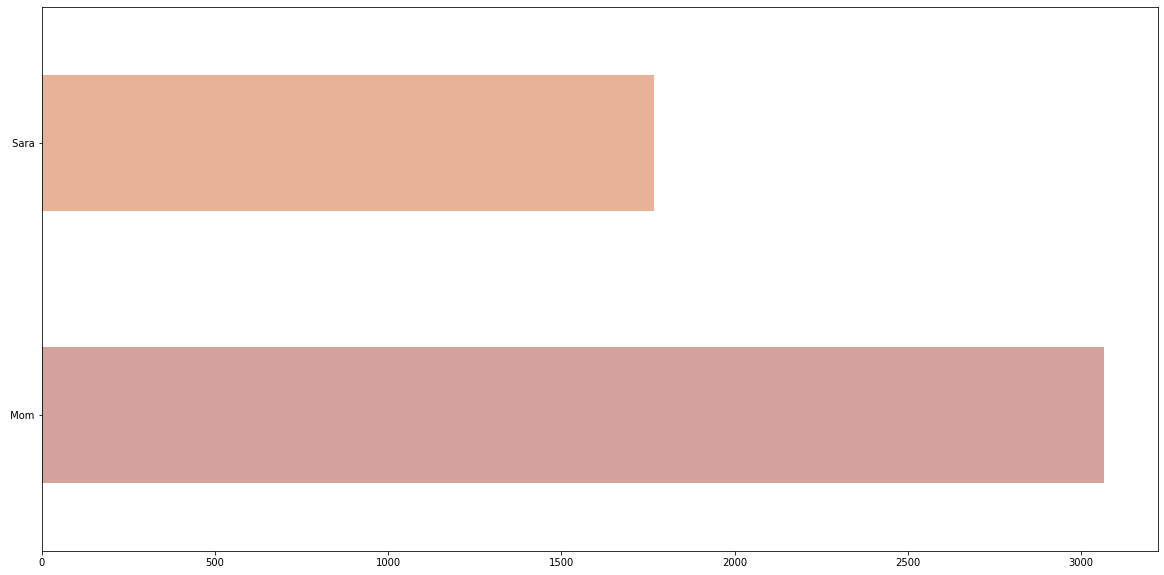

In [17]:
qty_message_author = data['person'].value_counts()
qty_message_author.plot(kind='barh',figsize=(20,10), color=['#D4A29C', '#E8B298', '#EDCC8B', '#BDD1C5', '#9DAAA2'])
qty_message_author

**To find out the most used words in chat, following this steps**

1. Using nltk stopwords, to remove some words from our data
2. Generate a new DataFrame copying chat DataFrame selecting author and message columns
3. Separate each word of each message to make a row with each of them
4. Use "remove_emoji" function, to not consider emojis as common words
5. Remove empty or NaN rows
6. Unifying every laughing text just in a "haha"
8. Grouping most common words then count their repetitions
9. Using plotly make a nice chart with top 10 common words

In [18]:
commond_words = data[['person','message']].copy()

from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')

stopwords = list(STOPWORDS)
extra = ["<multimedia", "omitido>", "k", "d","si","multimedia", "omitido"]
stopwords = stopwords + extra
commond_words["message"] = (commond_words["message"]
                           .str.lower()
                           .str.split()
                           .apply(lambda x: [item for item in x if item not in stopwords])
                           .explode()
                           .reset_index(drop=True)
                 )

#commond_words['message']= commond_words['message'].apply(remove_emoji)
commond_words['message']= commond_words['message'].replace('nan', np.NaN)
commond_words['message']= commond_words['message'].replace('', np.NaN)
commond_words['message']= commond_words.message.str.replace(r"(a|h)?(ha)+(a|h)?", "haha")
commond_words['message']= commond_words.message.str.replace(r"(a|h)?(haha)+(a|h)?", "haha")


words_dict = dict(Counter(commond_words.message))
words_dict = sorted(words_dict.items(), key=lambda x: x[1], reverse=True)

words_dict = pd.DataFrame(words_dict, columns=['words', 'count'])

fig = px.bar(words_dict.head(10).dropna(), x='words', y='count',
                 labels={'words':'Common Words'}, 
                 height=400)
fig.update_traces(marker_color='#EDCC8B', marker_line_color='#D4A29C',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Commond Words Chart')
fig.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning:

The default value of regex will change from True to False in a future version.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning:

The default value of regex will change from True to False in a future version.



The most common word by person?

In [19]:
TopTen =5
author_commond_words =  (commond_words.set_index('person')['message']
                          .dropna()
                          .groupby(level=0)
                          .value_counts()
                          .groupby(level=0)
                          .head(TopTen)
                          .rename_axis(('person','words'))
                          .reset_index(name='count'))

l = author_commond_words.person.unique()
for i in range(len(l)):
    dummy_df = author_commond_words[author_commond_words['person'] == l[i]]
    print(dummy_df)
    print('Most Commond Words by', l[i])
    fig = px.bar(dummy_df, x='words', y='count',
                 labels={'words':'By Person Common Words'}, 
                 height=380)
    fig.update_traces(marker_color='#EDCC8B', marker_line_color='#D4A29C',
                  marker_line_width=1.5, opacity=0.6)
    fig.update_layout(title_text='By Person Commond Words Chart')
    fig.show()

  person    words  count
0    Mom     call     66
1    Mom      i’m     62
2    Mom  ‎missed     42
3    Mom     need     37
4    Mom    sara,     35
Most Commond Words by  Mom


  person    words  count
5   Sara      i’m     39
6   Sara  ‎missed     33
7   Sara     call     31
8   Sara     it’s     20
9   Sara     know     19
Most Commond Words by  Sara


# WordCloud
WordCloud is a cool visualization to see all "chat" words. We will use the WordCloud library for this.
Using a couple of new functions to plot our chart and to eliminate links to web sites that could be found in messages.

In [20]:
#function to display wordcloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

#function to remove urls from text
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

The default value of regex will change from True to False in a future version.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

The default value of regex will change from True to False in a future version.



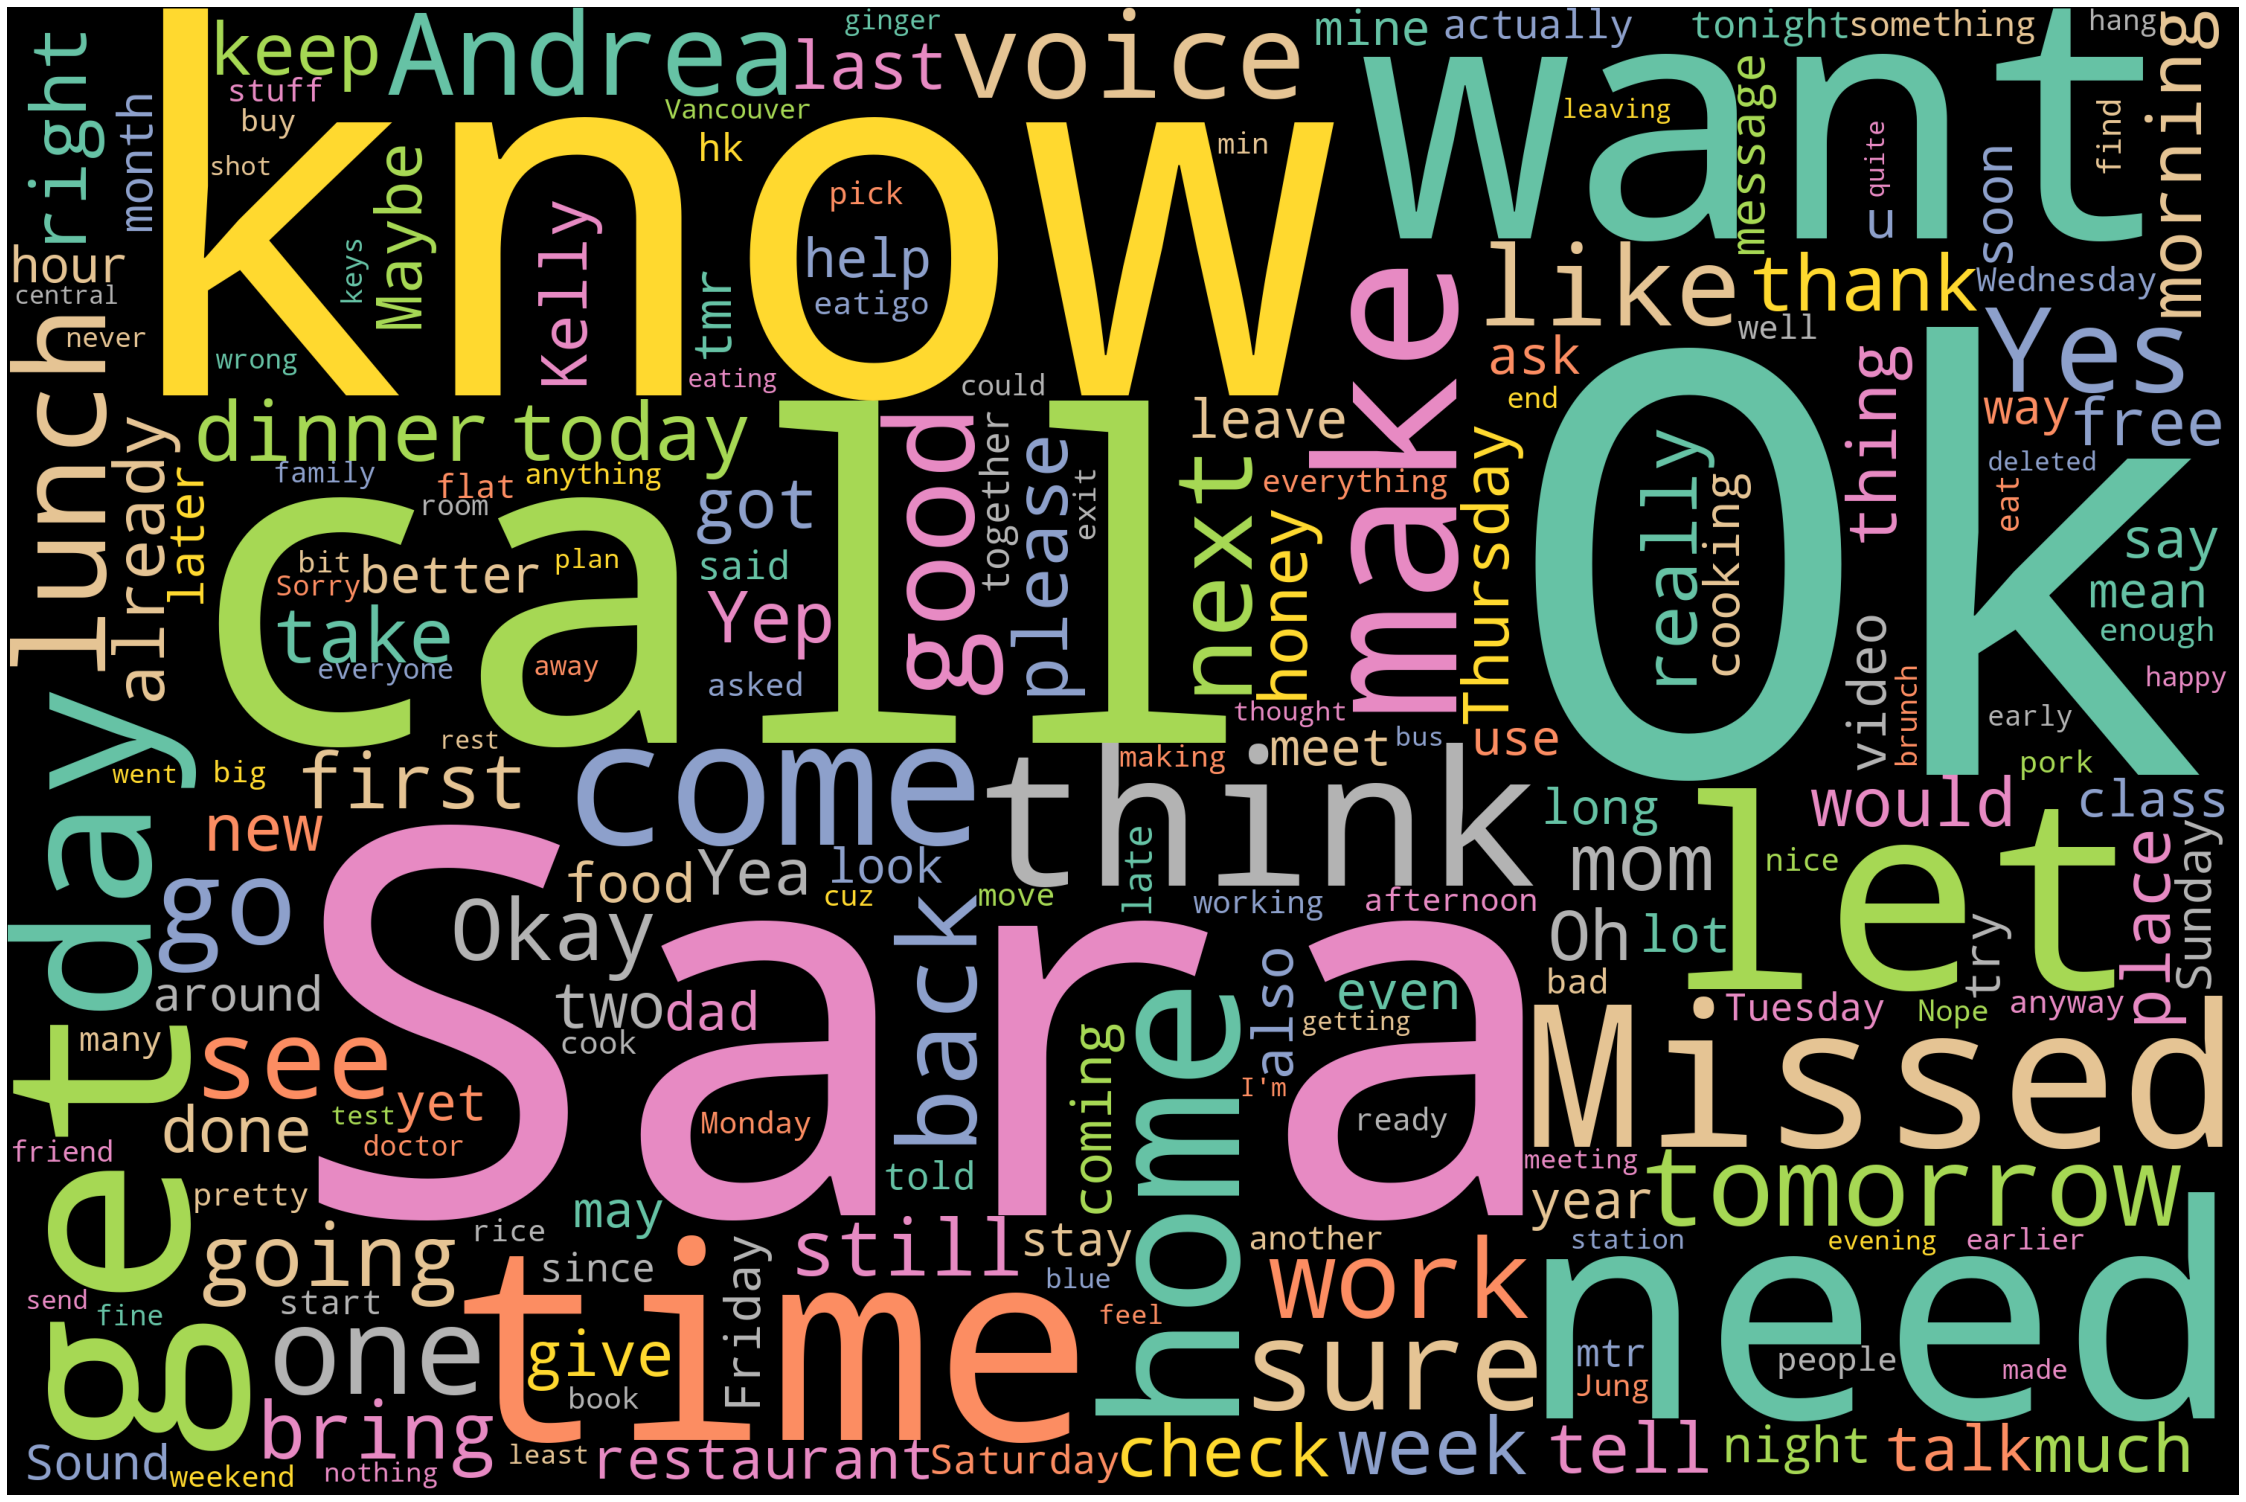

In [21]:
chat_word_cloud = data[['message']].copy()
#chat_word_cloud['message']= chat_word_cloud['message'].apply(remove_emoji)
chat_word_cloud['message']= chat_word_cloud['message'].apply(remove_urls)
chat_word_cloud['message']= chat_word_cloud['message'].replace('nan', np.NaN)
chat_word_cloud['message']= chat_word_cloud['message'].replace('', np.NaN)
chat_word_cloud['message']= chat_word_cloud.message.str.replace(r"(a|j)?(ja)+(a|j)?", "jaja")
chat_word_cloud['message']= chat_word_cloud.message.str.replace(r"(a|j)?(jaja)+(a|j)?", "jaja")
text = " ".join(review for review in chat_word_cloud.message.dropna())
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
background_color='black', colormap='Set2', collocations=False,
stopwords = stopwords).generate(text)
# Plot
plot_cloud(wordcloud)

# Emojis
What data can we get from emojis in group chat?

*A sum of all different used emojis.*

In [22]:
total_emojis_list = list(set([a for b in data['emoji'] for a in b]))
total_emojis = len(total_emojis_list)
print('Sum of all used Emojis', total_emojis)

Sum of all used Emojis 27


A new DataFrame shows the top ten emojis ordered from highest to lowest based on the number of repetitions.

In [23]:
total_emojis_list = list([a for b in data['emoji'] for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df.head(10)

,emoji,count
0,👍🏻,8
1,😬,5
2,👀,4
3,🙄,3
4,👍,2
5,😭,2
6,🏡,2
7,😌,2
8,👆,2
9,😂,2


A *Plotly TreeMap chart* shows variation in the amounts of use of each emoji.

In [24]:
fig = px.treemap(emoji_df, path= ['emoji'],
    values = emoji_df['count'].tolist(),
)
fig.show()

# Conclusion
I got very bored and decide to analyse whatsapp chat history...
* What are the highest chat frequency weekday?
* What is the time trend of texting?
* What are the most commonly used words?
And so on...
Turns out it was a very fun analytics!


# Potential Next Step
Let's do sentiment analysis on the messages too!